In [10]:
import torch
from synsense.net.auto import AutoSNN
from synsense.net.dataset import Dataset_Texture_Stream
import torch.nn as nn
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

In [11]:
from user import split_train_test
root = r'/media/xingchen/T7 Shield/Neuromorphic Data/Xingchen/processed/0220_dataset_iros/general_rotate'
train_size = 0.7
random_seed = 42
train_list, test_list = split_train_test(root, train_size, random_seed)
print(len(test_list))

1500


In [12]:
device = "pc"
gridsize = (130, 130)
after_crop_size = (260, 260, 1)
n_time_bins = 100

train_dataset = Dataset_Texture_Stream(train_list, device, gridsize, after_crop_size, n_time_bins)
test_dataset = Dataset_Texture_Stream(test_list, device, gridsize, after_crop_size, n_time_bins)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape, train_dataset[0][1], 
      train_dataset[0][0].max(), train_dataset[0][0].sum())

3500 1500
torch.Size([100, 1, 130, 130]) tensor(4) tensor(0.) tensor(0.)


In [13]:
model_path = r'/home/xingchen/PhD/synsense/test/0117-xytp/models/general_rotate-gs130-tl100-ddp.pt'
device = "cuda:0"
auto = AutoSNN(150)
auto.test(
    test_dataset,
    model_path,
    device
)

test accuracy:  71.47%


深度仅2.5mm的所有泛化

In [7]:
from torch.utils.data import DataLoader
import sinabs.layers as sl
device = "cuda:2"
model_path = r'/home/xingchen/PhD/synsense/test/0117-xytp/models/general_slide-gs130-tl100-ddp.pt'
model = torch.load(model_path, map_location=torch.device(device))
test_loader  = DataLoader(test_dataset, batch_size=50, drop_last=True)
test_target = torch.tensor([]).to(device)
test_predict = torch.tensor([]).to(device)
timesteps = test_dataset[0][0].shape[0] 

for i, (input, target) in enumerate(test_loader):
    with torch.no_grad():
        model.reset_states()
        input = input.to(device)
        target = target.to(device)
        test_target = torch.cat((test_target, target), 0).int()
    
        input = sl.FlattenTime()(input)
        output = model(input)
        output = output.view(50, timesteps, -1)
        sum_output = output.sum(1)
        predict = sum_output.argmax(1)
        test_predict = torch.cat((test_predict, predict), 0).int()

/tmp/ipykernel_2418508/1601924612.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device(device))


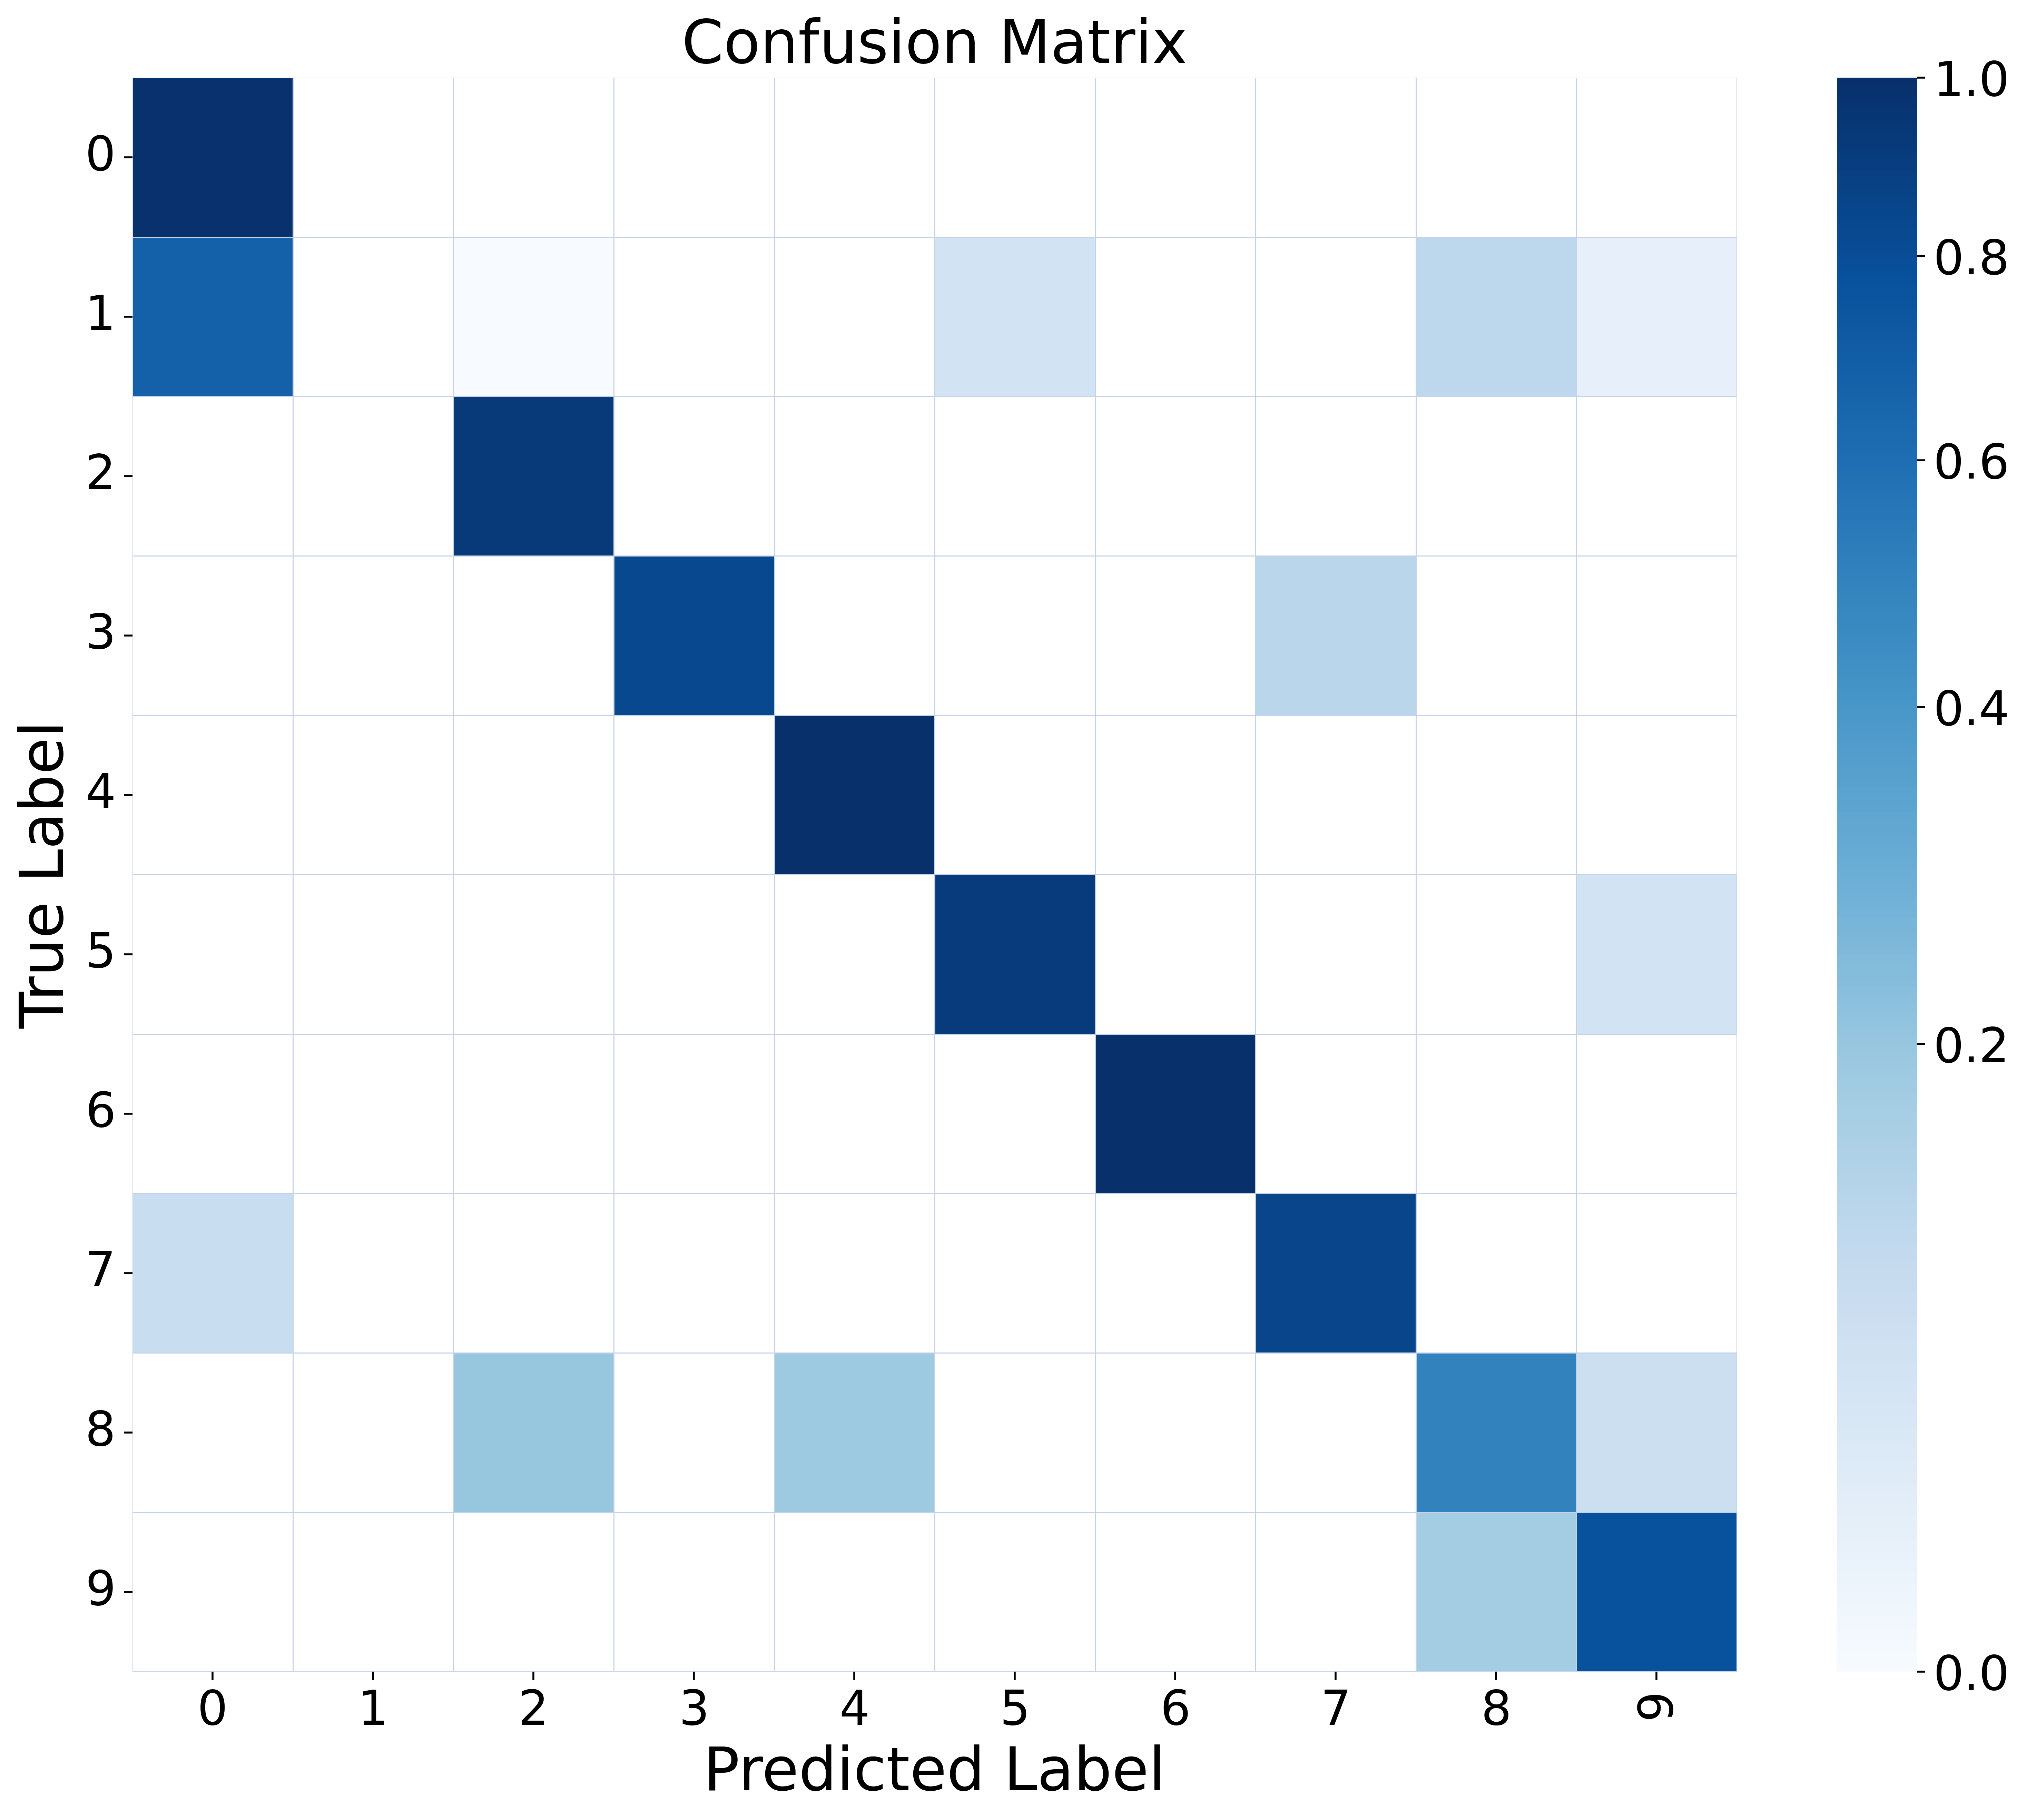

In [8]:
from matplotlib.colors import LinearSegmentedColormap, PowerNorm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
test_target = test_target.cpu()
test_predict = test_predict.cpu()
cm = confusion_matrix(test_target, test_predict, normalize='true')

colors = [
    (0.8, 0.88, 1.0),  # 浅蓝（接近白）
    (0.2, 0.4, 0.8),   # 中蓝
    (0.1, 0.2, 0.6)    # 深蓝
    ]
custom_cmap = LinearSegmentedColormap.from_list('blue_cmap', colors, N=256)
norm = norm = PowerNorm(gamma=0.5) 

plt.figure(dpi=500, figsize=(15, 12))
ax = sns.heatmap(cm, annot=False, fmt=".2f", cmap='Blues', linewidths=0.2, mask=(cm<=0.05),
            linecolor='#C5D3E8',
            xticklabels = list(np.arange(10)),
            yticklabels = list(np.arange(10)),
            norm=norm
            )
plt.xlabel('Predicted Label', fontsize=25)
plt.ylabel('True Label', fontsize=25)
plt.title('Confusion Matrix', fontsize=25)
ax.tick_params(axis='x', labelsize=20)  # 横轴标签字体大小
ax.tick_params(axis='y', labelsize=20)  # 纵轴标签字体大小
xticks_labels = ax.get_xticklabels()
xticks_labels[-1].set_rotation(90)  # 将最后一个标签旋转为90度
xticks_labels[-1].set_horizontalalignment('center')  # 设置水平对齐方式为居中
ax.set_xticklabels(xticks_labels)
plt.yticks(rotation=0)   # 纵轴标签保持水平
cbar = ax.collections[0].colorbar  # 获取colorbar对象
cbar.ax.tick_params(labelsize=20)  # 设置colorbar刻度字体大小
plt.show()